In [1]:
import pandas as pd 

data = pd.read_csv("data/counts_normalized_log2_shortlabels.csv")
data

Gene_Name  ARN_DHT_R1  ARN_DHT_R2  BIC_DHT_R1  BIC_DHT_R2  CTL_DHT_R1  \
0          A1BG    8.744624    7.910898    8.120633    7.754471    7.813781   
1      A1BG-AS1    8.866078    8.585575    8.686505    8.472798    8.588715   
2          A1CF    5.273291    4.907101    4.640495    5.133134    3.000000   
3           A2M    4.344827    3.723817    2.582046    3.983977    3.459432   
4       A2M-AS1    6.179589    6.154233    5.777922    6.202302    5.727920   
...         ...         ...         ...         ...         ...         ...   
39369    ZYG11A    6.833167    6.602474    6.581498    6.172963    6.303781   
39370    ZYG11B   10.219262   11.092731   10.653820   11.024912   10.710806   
39371       ZYX   11.478077   10.957510   11.194331   10.741136   11.661333   
39372     ZZEF1   11.625184   11.721834   11.876083   11.626989   12.298349   
39373      ZZZ3   11.040229   11.538534   11.208997   11.426370   11.181773   

       CTL_DHT_R2  ENZ_DHT_R1  ENZ_DHT_R2  
0        8.044341    8.912943    7.910619  
1        8.322901    8.886718    8.616526  
2        3.331796    5.159085    4.971521  
3        4.114662    3.717614    3.614688  
4        5.838587    5.706739    5.999977  
...           ...         ...         ...  
39369    6.010789    6.290488    6.560310  
39370   10.895888   10.053771   10.912960  
39371   11.003043   11.418783   10.958529  
39372   12.027975   11.582944   11.647604  
39373   11.402522   10.979313   11.442467  

[39374 rows x 9 columns]

In [2]:
# Vamos a calcular las medias de expresion y las desviaciones estandar (de la segunda columna en adelante)
stds = data.iloc[:, 1:].std(axis=1)
# Eliminamos las filas donde la desviacion estandar es 0
data_filtered = data[stds > 1e-4]
data_filtered

Gene_Name  ARN_DHT_R1  ARN_DHT_R2  BIC_DHT_R1  BIC_DHT_R2  CTL_DHT_R1  \
0          A1BG    8.744624    7.910898    8.120633    7.754471    7.813781   
1      A1BG-AS1    8.866078    8.585575    8.686505    8.472798    8.588715   
2          A1CF    5.273291    4.907101    4.640495    5.133134    3.000000   
3           A2M    4.344827    3.723817    2.582046    3.983977    3.459432   
4       A2M-AS1    6.179589    6.154233    5.777922    6.202302    5.727920   
...         ...         ...         ...         ...         ...         ...   
39369    ZYG11A    6.833167    6.602474    6.581498    6.172963    6.303781   
39370    ZYG11B   10.219262   11.092731   10.653820   11.024912   10.710806   
39371       ZYX   11.478077   10.957510   11.194331   10.741136   11.661333   
39372     ZZEF1   11.625184   11.721834   11.876083   11.626989   12.298349   
39373      ZZZ3   11.040229   11.538534   11.208997   11.426370   11.181773   

       CTL_DHT_R2  ENZ_DHT_R1  ENZ_DHT_R2  
0        8.044341    8.912943    7.910619  
1        8.322901    8.886718    8.616526  
2        3.331796    5.159085    4.971521  
3        4.114662    3.717614    3.614688  
4        5.838587    5.706739    5.999977  
...           ...         ...         ...  
39369    6.010789    6.290488    6.560310  
39370   10.895888   10.053771   10.912960  
39371   11.003043   11.418783   10.958529  
39372   12.027975   11.582944   11.647604  
39373   11.402522   10.979313   11.442467  

[30455 rows x 9 columns]

# Analisis de genes "diferencialmente expresados" de acuerdo con el enfoque de Random Forest

Número de genes con importancia > 0 en ARN: 1774
Número de genes con importancia > 0 en BIC: 1684
Número de genes con importancia > 0 en ENZ: 1680


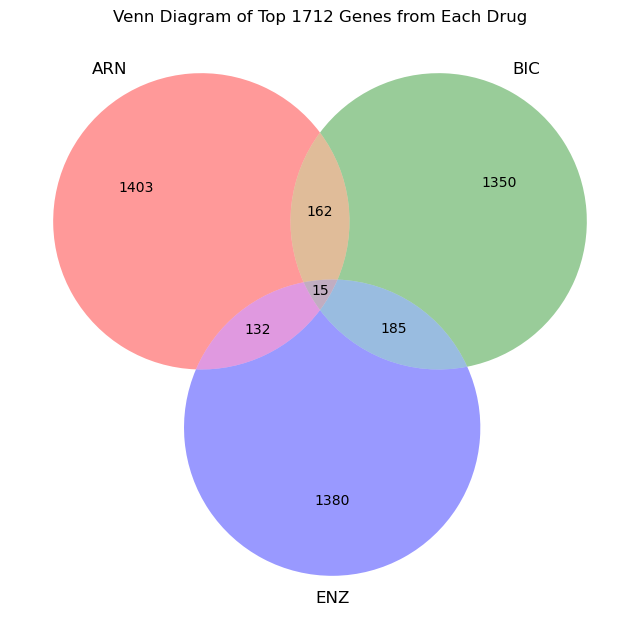

Total unique top genes across all analyses: 4627


In [3]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

genes_ARN = pd.read_csv("results/RandomForestDE/imp_ARN.csv")
genes_BIC = pd.read_csv("results/RandomForestDE/imp_BIC.csv")
genes_ENZ = pd.read_csv("results/RandomForestDE/imp_ENZ.csv")

# Vamos a contar cuantas filas de genes_ARN tienen en la columna de Importance un valor mayor a 0
print("Número de genes con importancia > 0 en ARN:", (genes_ARN["Importance"] > 0).sum())
print("Número de genes con importancia > 0 en BIC:", (genes_BIC["Importance"] > 0).sum())
print("Número de genes con importancia > 0 en ENZ:", (genes_ENZ["Importance"] > 0).sum())

promedio_genes_importancia_positiva = (
    (genes_ARN["Importance"] > 0).sum() +
    (genes_BIC["Importance"] > 0).sum() +
    (genes_ENZ["Importance"] > 0).sum()
) / 3

top_k = int(promedio_genes_importancia_positiva) # Usamos este valor como k para los top k genes

# Obtenemos los top k genes de cada análisis
top_genes_ARN = genes_ARN["Gene_Name"].head(top_k).tolist()
top_genes_BIC = genes_BIC["Gene_Name"].head(top_k).tolist()
top_genes_ENZ = genes_ENZ["Gene_Name"].head(top_k).tolist()

# Matriz de indices de Jaccard 
jaccard_matrix = pd.DataFrame(index=["ARN", "BIC", "ENZ"], columns=["ARN", "BIC", "ENZ"])
# Calcular índices de Jaccard
for method1, genes1 in [("ARN", top_genes_ARN), ("BIC", top_genes_BIC), ("ENZ", top_genes_ENZ)]:
    for method2, genes2 in [("ARN", top_genes_ARN), ("BIC", top_genes_BIC), ("ENZ", top_genes_ENZ)]:
        intersection = len(set(genes1).intersection(set(genes2)))
        union = len(set(genes1).union(set(genes2)))
        jaccard_index = intersection / union if union != 0 else 0
        jaccard_matrix.loc[method1, method2] = jaccard_index


# Matplotlib venn diagrams para 3 conjuntos
plt.figure(figsize=(8, 8))
venn3([set(top_genes_ARN), set(top_genes_BIC), set(top_genes_ENZ)],
      set_labels=('ARN', 'BIC', 'ENZ'))
plt.title(f'Venn Diagram of Top {top_k} Genes from Each Drug')
plt.show()

# Obtenemos un conjunto de genes en total (asociado a la union de los top k genes de cada analisis)
all_top_genes = set(top_genes_ARN).union(set(top_genes_BIC)).union(set(top_genes_ENZ))
print(f'Total unique top genes across all analyses: {len(all_top_genes)}')

In [4]:
# Vamos a guardar los genes de esta lista en un .txt top_genes_ARN
with open("results/NetworkAnalysis/ARN_gene_predictors.txt", "w") as f:
    for gene in top_genes_ARN:
        f.write(f"{gene}\n")

with open("results/NetworkAnalysis/BIC_gene_predictors.txt", "w") as f:
    for gene in top_genes_BIC:
        f.write(f"{gene}\n")

with open("results/NetworkAnalysis/ENZ_gene_predictors.txt", "w") as f:
    for gene in top_genes_ENZ:
        f.write(f"{gene}\n")

f.close()

In [5]:
# Vamos a cortar  data_filtered a los genes en all_top_genes
data_top_genes = data_filtered[data_filtered["Gene_Name"].isin(all_top_genes)]
data_top_genes

Gene_Name  ARN_DHT_R1  ARN_DHT_R2  BIC_DHT_R1  BIC_DHT_R2  CTL_DHT_R1  \
4        A2M-AS1    6.179589    6.154233    5.777922    6.202302    5.727920   
6          A2MP1    2.543495    3.881558    2.319128    1.311694    3.169925   
36          AATK    8.546415    8.066872    8.331900    7.982970    8.467606   
40        ABCA10    2.956427    1.337166    2.804355    2.445458    1.584963   
43        ABCA13    0.975263    0.000000    0.000000    1.311694    1.000000   
...          ...         ...         ...         ...         ...         ...   
39328     ZSCAN1    0.000000    0.000000    1.582629    0.000000    1.000000   
39331  ZSCAN12P1    5.236797    4.381636    4.244611    4.538223    4.643856   
39352     ZSWIM1    9.368020    9.855003    9.813486    9.781393    9.893302   
39357     ZSWIM6    9.465863    9.609298    9.506279    9.203310    9.405141   
39369     ZYG11A    6.833167    6.602474    6.581498    6.172963    6.303781   

       CTL_DHT_R2  ENZ_DHT_R1  ENZ_DHT_R2  
4        5.838587    5.706739    5.999977  
6        2.687325    4.505039    2.954176  
36       8.230092    8.521236    8.383681  
40       1.492482    2.161260    1.087450  
43       0.000000    1.452346    1.700424  
...           ...         ...         ...  
39328    0.000000    1.849915    1.700424  
39331    4.907834    5.682553    4.409369  
39352    9.907584    9.314172    9.760281  
39357    9.201260    9.403815    9.374201  
39369    6.010789    6.290488    6.560310  

[4612 rows x 9 columns]

# Construccion de redes usando OneSample NEtwork LIONESS

In [6]:
import numpy as np
import pandas as pd

def build_drug_delta_networks_lioness_corr_named(
    data_filtered: pd.DataFrame,
    K: int = 3000,
    use_zscore: bool = False,
    dtype=np.float32
):
    """
    Construye redes LIONESS de coexpresión (Pearson) por muestra
    y retorna las 3 redes finales por droga vs CTL
    como DataFrames con nombres de genes en filas/columnas.

    Retorna
    -------
    genes_f : np.ndarray
        Lista de genes tras filtrado.
    delta_networks_df : dict[str, pd.DataFrame]
        DataFrames (KxK) con:
            ARN = E_mean_ARN - E_mean_CTL
            BIC = E_mean_BIC - E_mean_CTL
            ENZ = E_mean_ENZ - E_mean_CTL
    E_mean_drug_df : dict[str, pd.DataFrame]
        Redes promedio por droga (incluye CTL).
    E_by_sample_df : dict[str, pd.DataFrame]
        Redes LIONESS por muestra.
    """

    
    # 1) Definir grupos
    
    drug_groups = {
        "ARN": ["ARN_DHT_R1", "ARN_DHT_R2"],
        "BIC": ["BIC_DHT_R1", "BIC_DHT_R2"],
        "ENZ": ["ENZ_DHT_R1", "ENZ_DHT_R2"],
        "CTL": ["CTL_DHT_R1", "CTL_DHT_R2"],
    }
    samples = sum(drug_groups.values(), [])

    missing = [c for c in samples if c not in data_filtered.columns]
    if missing:
        raise ValueError(f"Faltan columnas esperadas: {missing}")

    
    # 2) Matriz de expresión
    
    genes = data_filtered["Gene_Name"].to_numpy()
    X = data_filtered[samples].to_numpy(dtype=float)  # G x 8

    
    # 3) Opcional: z-score por gen
    
    if use_zscore:
        mu = X.mean(axis=1, keepdims=True)
        sd = X.std(axis=1, ddof=1, keepdims=True)

        mask_nonzero = (sd[:, 0] > 0)
        X = X[mask_nonzero]
        genes = genes[mask_nonzero]
        mu = mu[mask_nonzero]
        sd = sd[mask_nonzero]

        X = (X - mu) / sd

    G, N = X.shape  # N debe ser 8

    
    # 4) Filtrado por varianza
    
    vars_ = X.var(axis=1)
    K_eff = min(K, G)
    idx = np.argsort(vars_)[::-1][:K_eff]

    X_f = X[idx, :].astype(dtype, copy=False)
    genes_f = genes[idx]

    
    # 5) Red base: correlación gen-gen
    
    def base_network_corr(X_mat):
        return np.corrcoef(X_mat)

    N = X_f.shape[1]

    E_all = base_network_corr(X_f).astype(dtype, copy=False)

    
    # 6) LIONESS por muestra
    
    E_by_sample = {}
    for j, s in enumerate(samples):
        mask = np.ones(N, dtype=bool)
        mask[j] = False

        E_minus = base_network_corr(X_f[:, mask]).astype(dtype, copy=False)
        E_q = N * E_all - (N - 1) * E_minus
        E_by_sample[s] = E_q.astype(dtype, copy=False)

    
    # 7) Promedio por droga
    
    E_mean_drug = {}
    for drug, slist in drug_groups.items():
        mats = [E_by_sample[s] for s in slist]
        E_mean_drug[drug] = np.mean(mats, axis=0).astype(dtype, copy=False)

    
    # 8) Redes finales de efecto vs CTL
    
    E_ctl = E_mean_drug["CTL"]
    delta_networks = {}
    for drug in ["ARN", "BIC", "ENZ"]:
        delta_networks[drug] = (E_mean_drug[drug] - E_ctl).astype(dtype, copy=False)

    
    # 9) Convertir a DataFrames con nombres
    
    def to_df(M):
        return pd.DataFrame(M, index=genes_f, columns=genes_f)

    E_by_sample_df = {s: to_df(M) for s, M in E_by_sample.items()}
    E_mean_drug_df = {d: to_df(M) for d, M in E_mean_drug.items()}
    delta_networks_df = {d: to_df(M) for d, M in delta_networks.items()}

    return genes_f, delta_networks_df, E_mean_drug_df, E_by_sample_df


In [7]:
genes_f, delta_df, mean_df, sample_df = build_drug_delta_networks_lioness_corr_named(
        data_top_genes,
        K=3000,
        use_zscore=False
    )

ARN_net = delta_df["ARN"]
BIC_net = delta_df["BIC"]
ENZ_net = delta_df["ENZ"]

ARN_net.iloc[:5, :5]


/home/manager/miniconda/envs/WCS2025/lib/python3.14/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/manager/miniconda/envs/WCS2025/lib/python3.14/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


ORM2      HPGD       SHH     ACADL    ARLNC1
ORM2    0.000000 -0.162178 -0.092370 -0.237691 -0.120619
HPGD   -0.162178  0.000000  0.197176 -0.572060 -0.198120
SHH    -0.092370  0.197176  0.000000  0.636520 -0.014575
ACADL  -0.237691 -0.572060  0.636520  0.000000 -0.706357
ARLNC1 -0.120619 -0.198120 -0.014575 -0.706357  0.000000

In [8]:
pd.DataFrame(ARN_net)

ORM2      HPGD       SHH     ACADL    ARLNC1      SIX2  \
ORM2          0.000000 -0.162178 -0.092370 -0.237691 -0.120619 -0.557559   
HPGD         -0.162178  0.000000  0.197176 -0.572060 -0.198120 -0.100513   
SHH          -0.092370  0.197176  0.000000  0.636520 -0.014575  0.162556   
ACADL        -0.237691 -0.572060  0.636520  0.000000 -0.706357  0.636458   
ARLNC1       -0.120619 -0.198120 -0.014575 -0.706357  0.000000 -0.483992   
...                ...       ...       ...       ...       ...       ...   
CDSN         -1.498914 -0.418769  0.290004 -1.256430 -0.773833 -0.721783   
SASS6        -0.179846 -0.407553  0.463272 -0.292727 -0.516364  0.459005   
UBXN7         0.295022 -0.093035  0.337447  0.664356 -0.269134  0.607249   
LOC101927829  0.936487  0.278104 -0.784528  0.503644  1.029826 -0.532218   
LINC01436     0.936487  0.278104 -0.784528  0.503644  1.029826 -0.532218   

              LOC101928336     KRT78   HSD17B2  TRIM49D2  ...      AMN1  \
ORM2             -1.267560  1.211126 -0.710461 -0.158658  ...  0.177188   
HPGD             -0.752662  0.495806 -0.532192 -0.112814  ...  0.505596   
SHH               1.152998 -1.096831  0.615590  0.159842  ... -0.088161   
ACADL            -1.769060  0.777035 -1.158216 -0.360648  ...  0.192259   
ARLNC1           -0.843034  1.275621 -0.430543 -0.198571  ...  0.384782   
...                    ...       ...       ...       ...  ...       ...   
CDSN             -0.236550  0.310849 -0.836405 -0.878413  ...  1.380973   
SASS6            -1.384520  0.591061 -0.659202 -0.199828  ...  0.301640   
UBXN7            -0.642115  0.611390 -0.438418  0.070392  ... -0.285817   
LOC101927829      0.673123  0.000000  0.815555  0.464205  ... -1.035713   
LINC01436         0.673123  0.000000  0.815555  0.464205  ... -1.035713   

                 NSDHL      LTN1     FHOD3     LYRM7      CDSN     SASS6  \
ORM2         -1.368567  1.189557  2.359736 -0.448627 -1.498914 -0.179846   
HPGD         -0.633779  0.888896  1.165895 -0.804933 -0.418769 -0.407553   
SHH           0.790729 -0.339022 -1.427345  1.284685  0.290004  0.463272   
ACADL        -1.982983  1.801131  2.489069 -0.124816 -1.256430 -0.292727   
ARLNC1       -0.789275  0.645682  1.540040 -1.078458 -0.773833 -0.516364   
...                ...       ...       ...       ...       ...       ...   
CDSN         -0.195598  0.294985  0.196999 -0.751292  0.000000 -0.941390   
SASS6        -1.103578  1.133471  1.541979 -0.425585 -0.941390  0.000000   
UBXN7        -1.239704  0.971435  1.235814  0.639459 -0.582743  0.125432   
LOC101927829  0.623932 -0.951267 -0.425970 -0.092592  0.356634  0.247613   
LINC01436     0.623932 -0.951267 -0.425970 -0.092592  0.356634  0.247613   

                 UBXN7  LOC101927829  LINC01436  
ORM2          0.295022      0.936487   0.936487  
HPGD         -0.093035      0.278104   0.278104  
SHH           0.337447     -0.784528  -0.784528  
ACADL         0.664356      0.503644   0.503644  
ARLNC1       -0.269134      1.029826   1.029826  
...                ...           ...        ...  
CDSN         -0.582743      0.356634   0.356634  
SASS6         0.125432      0.247613   0.247613  
UBXN7         0.000000      0.635729   0.635729  
LOC101927829  0.635729      0.000000   0.000000  
LINC01436     0.635729      0.000000   0.000000  

[3000 rows x 3000 columns]

In [9]:
import networkx as nx
import numpy as np
import pandas as pd

def adjacency_to_graph(
    A: pd.DataFrame,
    method: str = "quantile",
    q: float = 0.99,
    abs_weights: bool = True,
    remove_self_loops: bool = True,
    min_edges: int = 1
):
    """
    Convierte matriz de adyacencia (DataFrame) a grafo ponderado.

    Mejoras vs versión anterior:
    - Manejo explícito de NaNs/inf.
    - nanquantile para evitar thr=NaN.
    - Fallback si el método produce 0 aristas.
    """

    if not isinstance(A, pd.DataFrame):
        raise TypeError("A debe ser un pandas DataFrame con index/columns = genes.")

    M = A.copy()

    # 1) Asegurar numérico y reemplazar inf por NaN
    M = M.apply(pd.to_numeric, errors="coerce")
    M.replace([np.inf, -np.inf], np.nan, inplace=True)

    # 2) Opcional: quitar diagonal
    if remove_self_loops:
        np.fill_diagonal(M.values, 0.0)

    W = M.values.astype(float, copy=False)
    W_abs = np.abs(W) if abs_weights else W

    K = W.shape[0]
    if K < 2:
        G = nx.Graph()
        G.add_nodes_from(M.index.tolist())
        return G

    # 3) Tomar triángulo superior
    iu = np.triu_indices(K, k=1)
    vals = W_abs[iu]

    # 4) Filtrar valores no finitos para definir umbral
    finite_mask = np.isfinite(vals)
    vals_f = vals[finite_mask]

    # Si no hay valores finitos, no hay nada que hacer
    genes = M.index.to_list()
    G = nx.Graph()
    G.add_nodes_from(genes)

    if vals_f.size == 0:
        return G

    # 5) Definir umbral según método
    if method == "quantile":
        # q=0.99 conserva el top 1% más fuerte
        thr = np.nanquantile(vals_f, q)
    elif method == "threshold":
        # aquí q se interpreta como umbral absoluto
        thr = float(q)
    else:
        raise ValueError("method debe ser 'quantile' o 'threshold'.")

    if not np.isfinite(thr):
        thr = np.nanmax(vals_f)

    keep = W_abs >= thr

    # 6) Construir aristas
    edges = []
    for i, j in zip(*iu):
        if keep[i, j] and np.isfinite(W[i, j]):
            edges.append((genes[i], genes[j], float(W[i, j])))

    # 7) Fallback si quedó vacío
    if len(edges) < min_edges and method == "quantile":
        # Reducimos exigencia del cuantil automáticamente
        # (sin preguntarte nada) para no dejarte con 0 aristas
        for q2 in [0.98, 0.95, 0.90, 0.85]:
            thr2 = np.nanquantile(vals_f, q2)
            if not np.isfinite(thr2):
                continue
            keep2 = W_abs >= thr2
            edges = []
            for i, j in zip(*iu):
                if keep2[i, j] and np.isfinite(W[i, j]):
                    edges.append((genes[i], genes[j], float(W[i, j])))
            if len(edges) >= min_edges:
                break

    # 8) Crear grafo
    G.add_weighted_edges_from(edges, weight="weight")
    return G


In [10]:
G_ARN = adjacency_to_graph(ARN_net, method="quantile", q=0.99, min_edges=10)
G_BIC = adjacency_to_graph(BIC_net, method="quantile", q=0.99, min_edges=10)
G_ENZ = adjacency_to_graph(ENZ_net, method="quantile", q=0.99, min_edges=10)

print(G_ARN.number_of_nodes(), G_ARN.number_of_edges())
print(G_BIC.number_of_nodes(), G_BIC.number_of_edges())
print(G_ENZ.number_of_nodes(), G_ENZ.number_of_edges())

3000 44269
3000 44507
3000 44417


In [11]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

def plot_weighted_network(
    G,
    title=None,
    layout="spring",
    seed=7,
    iterations=80,
    figsize=(5, 5),
    dpi=220,
    node_size=6,
    node_alpha=0.55,
    edge_alpha=0.22,
    edge_width=0.45,
):
    """
    Visualización estética para grafos grandes (~3000 nodos, ~40-50k aristas).
    - Elimina nodos aislados (grado 0) antes de graficar.
    - Color de aristas proporcional al peso.
    - Sin leyenda ni colorbar.
    - Sin labels de nodos.
    - Usa colormap divergente centrado en 0 si hay pesos +/-.

    layout:
      - "spring" (default): no depende de librerías externas
      - "sfdp": usa Graphviz si tienes pygraphviz instalado (mejor para grafos grandes)
      - "forceatlas2": si tu versión de networkx lo incluye
    """

    if G.number_of_nodes() == 0:
        raise ValueError("El grafo no tiene nodos.")

    # -------------------------
    # 0) Eliminar nodos aislados (grado 0)
    # -------------------------
    H = G.copy()
    isolates = list(nx.isolates(H))
    if isolates:
        H.remove_nodes_from(isolates)

    # Si tras limpiar no quedan nodos o aristas, manejar salida bonita
    if H.number_of_nodes() == 0:
        print("Tras eliminar nodos aislados, el grafo quedó sin nodos.")
        plt.figure(figsize=figsize, dpi=dpi)
        plt.axis("off")
        if title:
            plt.title(title)
        plt.show()
        return None

    if H.number_of_edges() == 0:
        print("Tras eliminar nodos aislados, el grafo no tiene aristas.")
        plt.figure(figsize=figsize, dpi=dpi)
        plt.axis("off")
        if title:
            plt.title(title)
        plt.show()
        return None

    # -------------------------
    # 1) Layout
    # -------------------------
    n = H.number_of_nodes()

    if layout == "sfdp":
        try:
            from networkx.drawing.nx_agraph import graphviz_layout
            pos = graphviz_layout(H, prog="sfdp")
        except Exception:
            k = 1.0 / np.sqrt(n)
            pos = nx.spring_layout(H, seed=seed, k=k, iterations=iterations)

    elif layout == "forceatlas2":
        try:
            pos = nx.forceatlas2_layout(H, seed=seed, iterations=iterations)
        except Exception:
            k = 1.0 / np.sqrt(n)
            pos = nx.spring_layout(H, seed=seed, k=k, iterations=iterations)

    else:
        k = 1.0 / np.sqrt(n)
        pos = nx.spring_layout(H, seed=seed, k=k, iterations=iterations)

    # -------------------------
    # 2) Extraer pesos
    # -------------------------
    weights = np.array(
        [d.get("weight", 0.0) for _, _, d in H.edges(data=True)],
        dtype=float
    )
    weights = weights[np.isfinite(weights)]

    if weights.size == 0:
        print("No se encontraron pesos finitos en las aristas.")
        return pos

    vmin = float(np.min(weights))
    vmax = float(np.max(weights))

    # -------------------------
    # 3) Normalización de color
    # -------------------------
    if vmin < 0 < vmax:
        _ = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)  # informativo
        # Nota: nx.draw_networkx_edges usa edge_vmin/edge_vmax directamente.
    # else: no hace falta norm explícito

    # -------------------------
    # 4) Dibujar
    # -------------------------
    plt.figure(figsize=figsize, dpi=dpi)
    ax = plt.gca()
    ax.set_axis_off()

    nx.draw_networkx_nodes(
        H, pos,
        node_size=node_size,
        node_color="black",
        alpha=node_alpha,
        linewidths=0,
        ax=ax
    )

    nx.draw_networkx_edges(
        H, pos,
        edge_color=[d.get("weight", 0.0) for _, _, d in H.edges(data=True)],
        edge_cmap=plt.cm.coolwarm,
        edge_vmin=vmin,
        edge_vmax=vmax,
        width=edge_width,
        alpha=edge_alpha,
        ax=ax
    )

    if title:
        plt.title(title)

    plt.tight_layout()
    plt.show()

    # Si te interesa reutilizar el grafo limpio:
    return pos, H


# Analisis de comunidades utilizando Louvain

In [13]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


def run_louvain(G, weight="weight", seed=7, resolution=1.0):
    """
    Ejecuta Louvain y devuelve:
    - partition: dict nodo -> id_comunidad
    - communities: lista de sets de nodos
    """

    # --- Opción A: Louvain nativo de Networun_louvainrkX (si está disponible) ---
    try:
        from networkx.algorithms.community import louvain_communities

        communities = louvain_communities(
            G,
            weight=weight,
            seed=seed,
            resolution=resolution
        )
        partition = {}
        for cid, comm in enumerate(communities):
            for n in comm:
                partition[n] = cid

        return partition, communities

    except Exception:
        pass

    # --- Opción B: python-louvain (community) ---
    # pip install python-louvain
    try:
        import community as community_louvain

        partition = community_louvain.best_partition(
            G,
            weight=weight,
            random_state=seed,
            resolution=resolution
        )

        # reconstruir lista de sets
        comm_map = {}
        for n, cid in partition.items():
            comm_map.setdefault(cid, set()).add(n)
        communities = [comm_map[cid] for cid in sorted(comm_map.keys())]

        return partition, communities

    except ImportError as e:
        raise ImportError(
            "No encontré Louvain en NetworkX ni el paquete python-louvain.\n"
            "Instala con: pip install python-louvain"
        ) from e


def plot_louvain_communities(
    G,
    pos=None,
    title=None,
    weight="weight",
    seed=7,
    resolution=1.0,
    layout="spring",
    iterations=80,
    figsize=(5, 5),
    dpi=220,
    node_size=7,
    node_alpha=0.85,
    edge_alpha=0.18,
    edge_width=0.40,
):
    """
    Grafica un grafo grande con:
    - nodos coloreados por comunidad Louvain
    - aristas coloreadas por peso
    - sin leyenda / sin colorbar
    """

    if G.number_of_nodes() == 0:
        raise ValueError("El grafo no tiene nodos.")
    if G.number_of_edges() == 0:
        print("El grafo no tiene aristas.")
        plt.figure(figsize=figsize, dpi=dpi)
        plt.axis("off")
        if title:
            plt.title(title)
        plt.show()
        return None, None, pos

    # -------------------------
    # 1) Layout si no lo pasas
    # -------------------------
    if pos is None:
        n = G.number_of_nodes()
        if layout == "sfdp":
            try:
                from networkx.drawing.nx_agraph import graphviz_layout
                pos = graphviz_layout(G, prog="sfdp")
            except Exception:
                k = 1.0 / np.sqrt(n)
                pos = nx.spring_layout(G, seed=seed, k=k, iterations=iterations)
        else:
            k = 1.0 / np.sqrt(n)
            pos = nx.spring_layout(G, seed=seed, k=k, iterations=iterations)

    # -------------------------
    # 2) Louvain
    # -------------------------
    partition, communities = run_louvain(
        G,
        weight=weight,
        seed=seed,
        resolution=resolution
    )

    # vector de comunidad por nodo en el orden de G.nodes()
    nodes = list(G.nodes())
    comm_ids = np.array([partition[n] for n in nodes], dtype=int)

    # -------------------------
    # 3) Pesos de aristas
    # -------------------------
    edge_weights = np.array(
        [d.get(weight, 0.0) for _, _, d in G.edges(data=True)],
        dtype=float
    )
    edge_weights = edge_weights[np.isfinite(edge_weights)]
    if edge_weights.size == 0:
        vmin, vmax = -1.0, 1.0
    else:
        vmin, vmax = float(edge_weights.min()), float(edge_weights.max())

    # -------------------------
    # 4) Plot
    # -------------------------
    plt.figure(figsize=figsize, dpi=dpi)
    ax = plt.gca()
    ax.set_axis_off()

    # Nodos por comunidad
    # Usamos un colormap discreto amplio
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=nodes,
        node_color=comm_ids,
        cmap=plt.cm.tab20,     # suficiente para muchas comunidades
        node_size=node_size,
        alpha=node_alpha,
        linewidths=0,
        ax=ax
    )

    # Aristas por peso (divergente útil para ΔE)
    nx.draw_networkx_edges(
        G, pos,
        edge_color=[d.get(weight, 0.0) for _, _, d in G.edges(data=True)],
        edge_cmap=plt.cm.coolwarm,
        edge_vmin=vmin,
        edge_vmax=vmax,
        width=edge_width,
        alpha=edge_alpha,
        ax=ax
    )

    # Sin leyenda, sin colorbar
    if title:
        plt.title(title)

    plt.tight_layout()
    plt.show()

    return partition, communities, pos


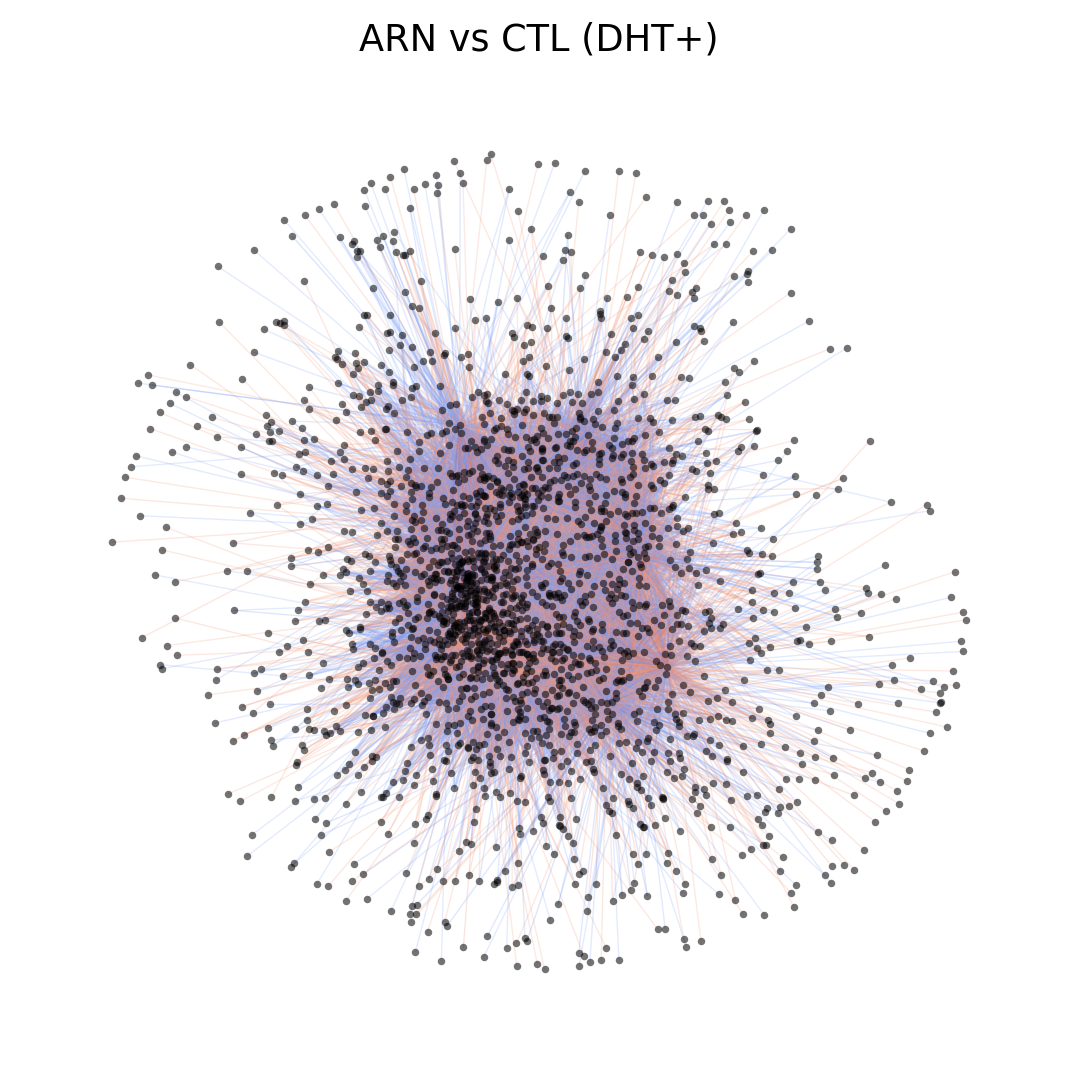

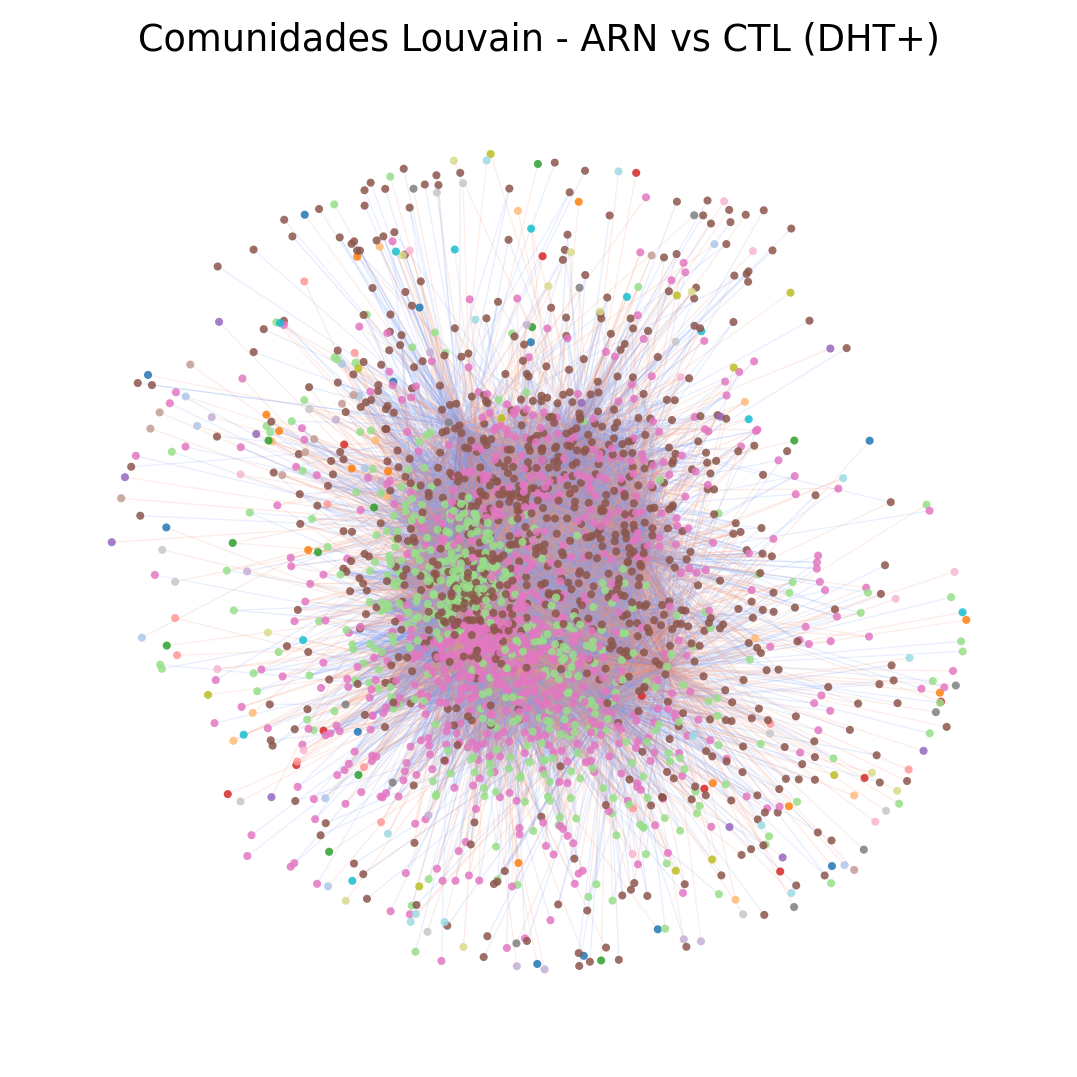

In [14]:
pos_arn, G_ARN_clean = plot_weighted_network(G_ARN, title="ARN vs CTL (DHT+)")
partition_arn, comms_arn, pos_arn = plot_louvain_communities(
    G_ARN_clean,
    pos=pos_arn,  # reutiliza layout para consistencia visual
    title="Comunidades Louvain - ARN vs CTL (DHT+)",
    resolution=1.0
)

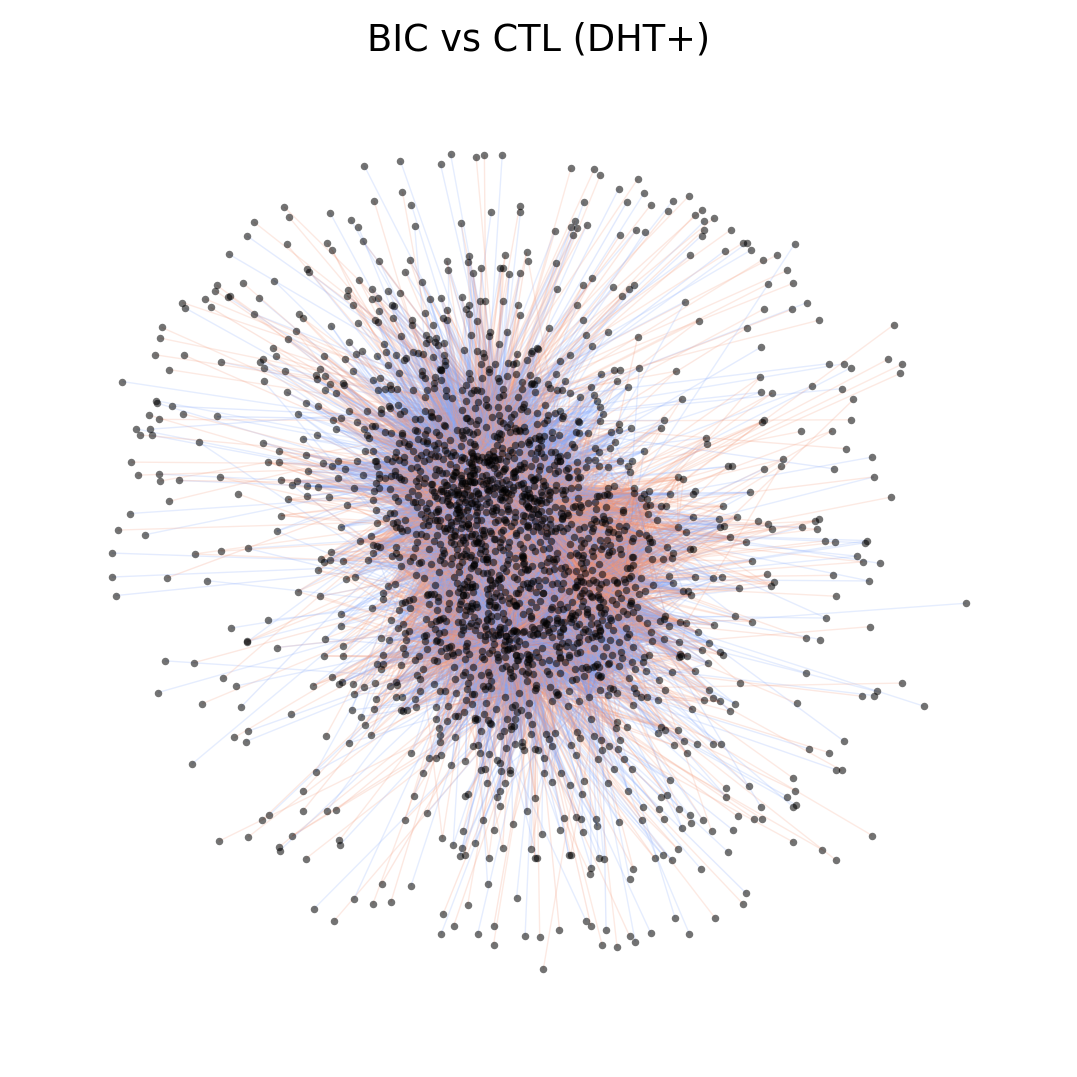

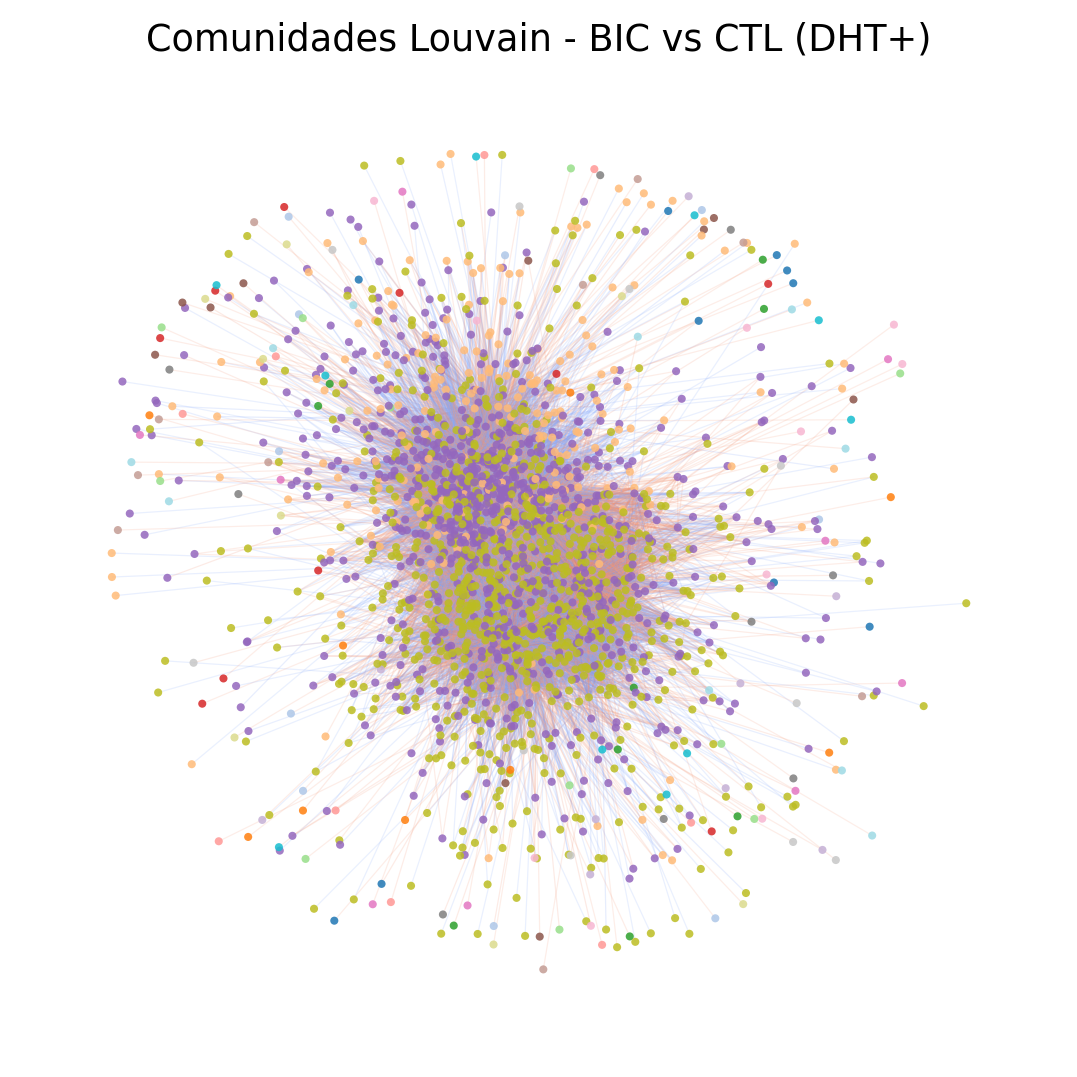

In [15]:
pos_bic, G_BIC_clean = plot_weighted_network(G_BIC, title="BIC vs CTL (DHT+)")
partition_bic, comms_bic, pos_bic = plot_louvain_communities(
    G_BIC_clean,
    pos=pos_bic,  # reutiliza layout para consistencia visual
    title="Comunidades Louvain - BIC vs CTL (DHT+)",
    resolution=1.0
)

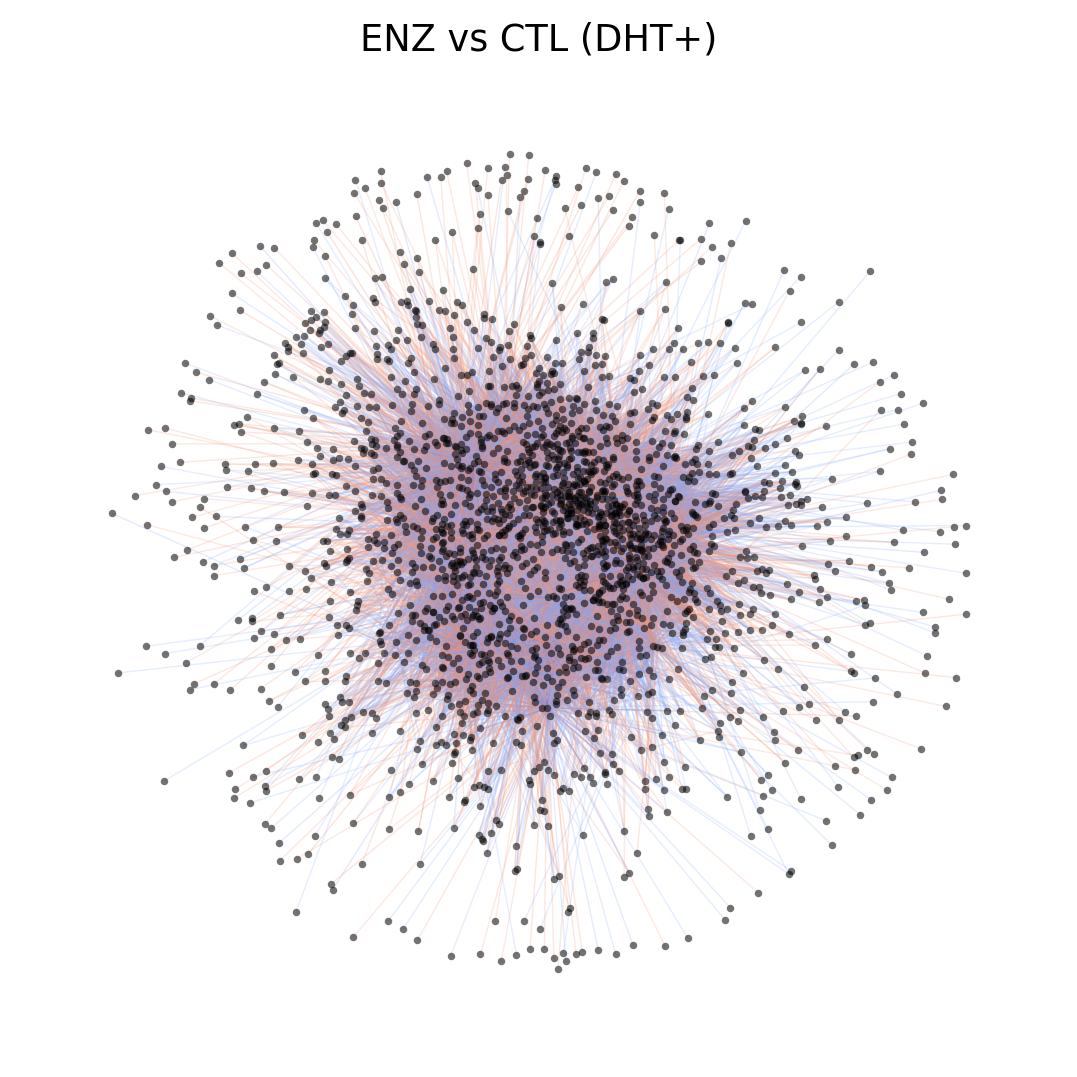

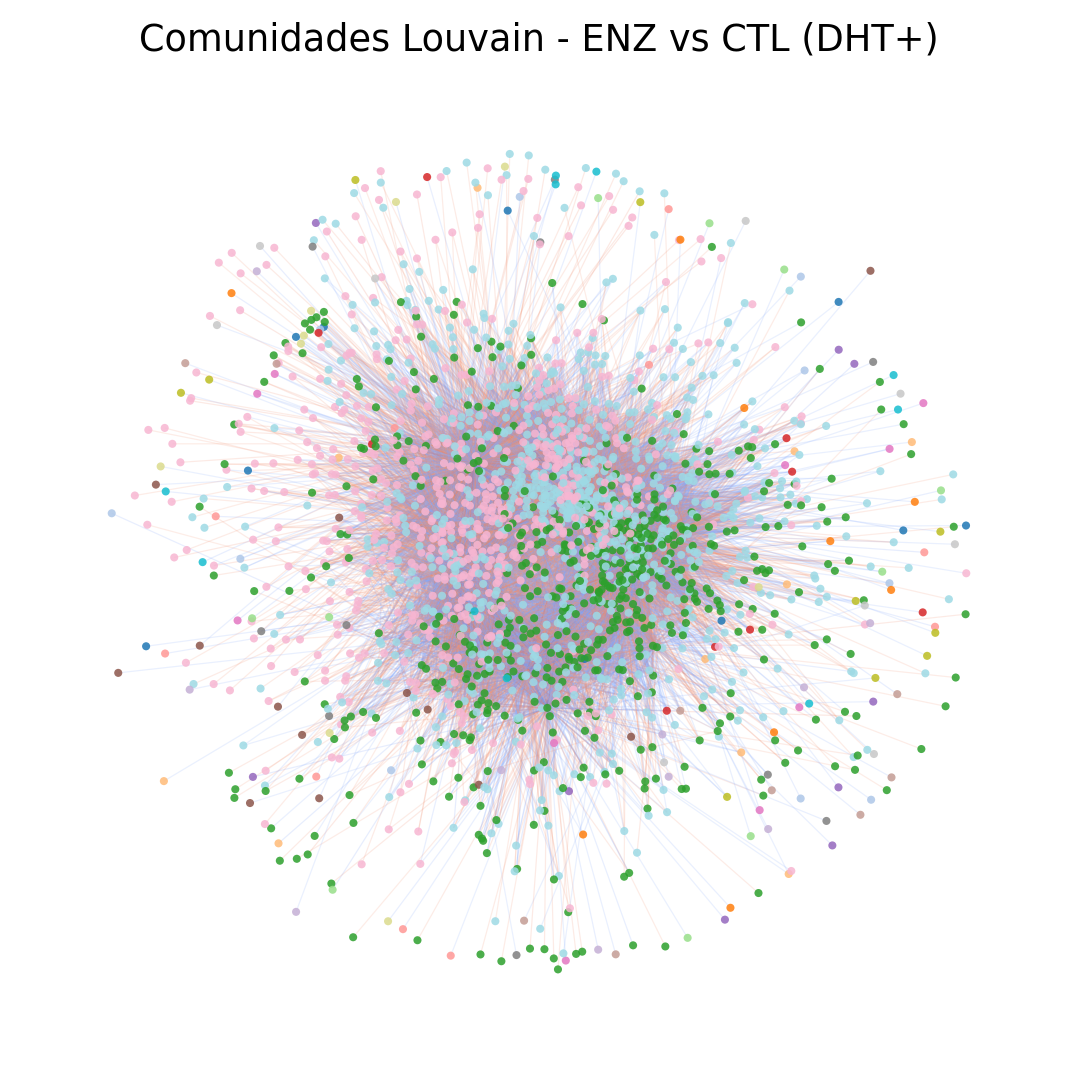

In [16]:
pos_znz, G_ENZ_clean = plot_weighted_network(G_ENZ, title="ENZ vs CTL (DHT+)")
partition_enx, comms_enz, pos_enz = plot_louvain_communities(
    G_ENZ_clean,
    pos=pos_znz,  # reutiliza layout para consistencia visual
    title="Comunidades Louvain - ENZ vs CTL (DHT+)",
    resolution=1.0
)

In [17]:
import numpy as np
import pandas as pd
import networkx as nx

def remove_isolates(G):
    """
    Devuelve una copia del grafo sin nodos aislados.
    Funciona para Graph y DiGraph.
    """
    H = G.copy()
    iso = list(nx.isolates(H))
    if iso:
        H.remove_nodes_from(iso)
    return H

def safe_float(x):
    try:
        if x is None:
            return np.nan
        return float(x)
    except Exception:
        return np.nan

def compute_basic_topology_metrics(G, weight="weight"):
    """
    Calcula métricas topológicas básicas.
    Para métricas de caminos/diámetro usa el componente conectado más grande.
    Para métricas 'ponderadas' usa |weight| cuando tiene sentido.

    Retorna un dict listo para DataFrame.
    """
    # 0) Normalizar tipo de grafo
    # Si por algún motivo fuera dirigido, lo pasamos a no dirigido para comparar topología global
    if G.is_directed():
        Gu = G.to_undirected(as_view=False)
    else:
        Gu = G

    # 1) Eliminar aislados
    H = remove_isolates(Gu)

    # Si quedó vacío:
    if H.number_of_nodes() == 0:
        return {
            "n_nodes": 0,
            "n_edges": 0,
            "density": np.nan,
            "n_components": 0,
            "giant_component_frac": np.nan,
            "avg_degree": np.nan,
            "avg_strength_abs": np.nan,
            "avg_clustering_unweighted": np.nan,
            "avg_clustering_weighted_abs": np.nan,
            "transitivity": np.nan,
            "assortativity_degree": np.nan,
            "avg_shortest_path_len_gc": np.nan,
            "diameter_gc": np.nan,
        }

    # 2) Métricas de tamaño/estructura básica
    n = H.number_of_nodes()
    m = H.number_of_edges()

    density = safe_float(nx.density(H))

    # Componentes
    comps = list(nx.connected_components(H))
    n_components = len(comps)
    gc = max(comps, key=len)
    gc_size = len(gc)
    giant_frac = gc_size / n if n > 0 else np.nan

    # 3) Grado promedio
    degrees = np.array([d for _, d in H.degree()], dtype=float)
    avg_degree = float(np.mean(degrees)) if degrees.size else np.nan

    # 4) "Strength" promedio (suma de |pesos| por nodo)
    # útil en tus redes delta (puede haber pesos +/-)
    strength = []
    for node in H.nodes():
        s = 0.0
        for _, _, d in H.edges(node, data=True):
            w = d.get(weight, 0.0)
            if np.isfinite(w):
                s += abs(float(w))
        strength.append(s)
    avg_strength_abs = float(np.mean(strength)) if len(strength) else np.nan

    # 5) Clustering
    # 5.1 No ponderado
    try:
        avg_clust_unw = float(nx.average_clustering(H))
    except Exception:
        avg_clust_unw = np.nan

    # 5.2 Ponderado usando |weight|
    # NetworkX no toma abs automáticamente, así que creamos un atributo auxiliar
    H_abs = H.copy()
    for u, v, d in H_abs.edges(data=True):
        w = d.get(weight, 0.0)
        d["weight_abs"] = abs(float(w)) if np.isfinite(w) else 0.0

    try:
        avg_clust_w = float(nx.average_clustering(H_abs, weight="weight_abs"))
    except Exception:
        avg_clust_w = np.nan

    # 6) Transitivity (global clustering)
    try:
        trans = float(nx.transitivity(H))
    except Exception:
        trans = np.nan

    # 7) Asortatividad por grado
    try:
        assort = float(nx.degree_assortativity_coefficient(H))
    except Exception:
        assort = np.nan

    # 8) Caminos y diámetro sobre el componente gigante
    H_gc = H.subgraph(gc).copy()

    try:
        avg_spl = float(nx.average_shortest_path_length(H_gc))
    except Exception:
        avg_spl = np.nan

    try:
        diam = float(nx.diameter(H_gc))
    except Exception:
        diam = np.nan

    return {
        "n_nodes": n,
        "n_edges": m,
        "density": density,
        "n_components": n_components,
        "giant_component_frac": giant_frac,
        "avg_degree": avg_degree,
        "avg_strength_abs": avg_strength_abs,
        "avg_clustering_unweighted": avg_clust_unw,
        "avg_clustering_weighted_abs": avg_clust_w,
        "transitivity": trans,
        "assortativity_degree": assort,
        "avg_shortest_path_len_gc": avg_spl,
        "diameter_gc": diam,
    }

def compare_three_networks(G_ARN, G_BIC, G_ENZ, weight="weight"):
    """
    Genera una tabla comparativa de topología para tus tres redes.
    """
    metrics = {
        "ARN": compute_basic_topology_metrics(G_ARN, weight=weight),
        "BIC": compute_basic_topology_metrics(G_BIC, weight=weight),
        "ENZ": compute_basic_topology_metrics(G_ENZ, weight=weight),
    }
    df_metrics = pd.DataFrame(metrics).T

    # Orden amigable de columnas
    col_order = [
        "n_nodes", "n_edges", "density",
        "n_components", "giant_component_frac",
        "avg_degree", "avg_strength_abs",
        "avg_clustering_unweighted", "avg_clustering_weighted_abs",
        "transitivity", "assortativity_degree",
        "avg_shortest_path_len_gc", "diameter_gc"
    ]
    df_metrics = df_metrics[[c for c in col_order if c in df_metrics.columns]]

    return df_metrics


In [18]:
df_topo = compare_three_networks(G_ARN, G_BIC, G_ENZ)

df_topo

n_nodes  n_edges   density  n_components  giant_component_frac  \
ARN   2264.0  44269.0  0.017281           1.0                   1.0   
BIC   2103.0  44507.0  0.020137           1.0                   1.0   
ENZ   2241.0  44417.0  0.017697           1.0                   1.0   

     avg_degree  avg_strength_abs  avg_clustering_unweighted  \
ARN   39.106890        140.977971                   0.014707   
BIC   42.327152        152.107263                   0.016581   
ENZ   39.640339        146.532984                   0.016069   

     avg_clustering_weighted_abs  transitivity  assortativity_degree  \
ARN                     0.008037      0.015282             -0.344609   
BIC                     0.008719      0.017212             -0.366880   
ENZ                     0.008715      0.011144             -0.351905   

     avg_shortest_path_len_gc  diameter_gc  
ARN                  2.802317          5.0  
BIC                  2.716713          5.0  
ENZ                  2.785812          5.0

# Filtrado de comunidades utilizando el criterio de aquellas con mayor peso de interaccion

In [19]:
from typing import List, Set, Dict, Tuple

In [20]:
def compute_module_scores(
    G: nx.Graph,
    communities: List[Set],
    weight: str = "weight",
    min_size: int = 30
) -> pd.DataFrame:
    """
    Calcula métricas de rewiring para cada comunidad.

    Parámetros
    ----------
    G : nx.Graph
        Grafo de rewiring (ΔE), con atributo 'weight'.
    communities : list of sets
        Lista de comunidades (cada elemento es un set de nodos).
    weight : str
        Nombre del atributo de peso en las aristas.
    min_size : int
        Tamaño mínimo de genes para considerar la comunidad en el ranking.

    Retorna
    -------
    df_scores : pd.DataFrame
        Columnas:
            community      : id interno (índice en 'communities')
            n_genes        : número de genes en la comunidad
            n_edges        : #de aristas internas
            S_intra_abs    : media de |peso| en las aristas internas
            B_mean         : media de peso (con signo) en aristas internas
            eligible       : True si pasa el filtro de tamaño y tiene aristas
    """
    rows = []

    for cid, C in enumerate(communities):
        # subgrafo interno
        sub = G.subgraph(C)
        n_genes = sub.number_of_nodes()
        n_edges = sub.number_of_edges()

        if n_edges > 0:
            w = np.array(
                [d.get(weight, 0.0) for _, _, d in sub.edges(data=True)],
                dtype=float
            )
            w = w[np.isfinite(w)]
            if w.size > 0:
                S_intra_abs = float(np.mean(np.abs(w)))
                B_mean = float(np.mean(w))
            else:
                S_intra_abs = 0.0
                B_mean = 0.0
        else:
            S_intra_abs = 0.0
            B_mean = 0.0

        eligible = (n_genes >= min_size) and (n_edges > 0)

        rows.append({
            "community": cid,
            "n_genes": n_genes,
            "n_edges": n_edges,
            "S_intra_abs": S_intra_abs,
            "B_mean": B_mean,
            "eligible": eligible,
        })

    df_scores = pd.DataFrame(rows)
    return df_scores


In [21]:
def select_representative_community(df_scores: pd.DataFrame) -> int:
    """
    Elige la comunidad "representativa":
    - entre las que tienen eligible=True, se queda con la de mayor S_intra_abs.
    - si ninguna es elegible, toma la de mayor S_intra_abs sin filtro.
    Retorna
    -------
    cid : int
        Índice de la comunidad elegida.
    """
    df_elig = df_scores[df_scores["eligible"]]
    if not df_elig.empty:
        cid = int(df_elig.sort_values("S_intra_abs", ascending=False).iloc[0]["community"])
    else:
        cid = int(df_scores.sort_values("S_intra_abs", ascending=False).iloc[0]["community"])
    return cid


In [22]:
def intramodular_strength(
    G: nx.Graph,
    community_nodes: Set,
    weight: str = "weight"
) -> Dict[str, float]:
    """
    Calcula strength intramodular de cada nodo en la comunidad:
        s_i^{(C)} = sum_{j in C} |w_{ij}|

    Retorna
    -------
    strength_dict : dict nodo -> strength
    """
    sub = G.subgraph(community_nodes)
    strength = {}
    for n in sub.nodes():
        s = 0.0
        for _, _, d in sub.edges(n, data=True):
            w = d.get(weight, 0.0)
            if np.isfinite(w):
                s += abs(float(w))
        strength[n] = s
    return strength

def top_hubs_in_community(
    G: nx.Graph,
    community_nodes: Set,
    weight: str = "weight",
    top_k: int = 20
) -> List[Tuple[str, float]]:
    """
    Devuelve los top_k hubs intramodulares ordenados por strength descendente.

    Retorna
    -------
    hubs : list of (gene, strength)
    """
    strength = intramodular_strength(G, community_nodes, weight=weight)
    hubs = sorted(strength.items(), key=lambda x: x[1], reverse=True)[:top_k]
    return hubs

In [23]:
def representative_module_and_hubs(
    G: nx.Graph,
    communities: List[Set],
    drug_name: str,
    weight: str = "weight",
    min_size: int = 30,
    top_k_hubs: int = 20
) -> Dict:
    """
    Obtiene la comunidad "más representativa" por rewiring para un fármaco
    y los top hubs intramodulares.

    Retorna
    -------
    result : dict
        {
          "drug"          : nombre del fármaco,
          "scores_table"  : DataFrame con métricas por comunidad,
          "rep_cid"       : id de la comunidad representativa,
          "rep_genes"     : lista de genes en la comunidad representativa,
          "rep_hubs"      : lista de (gen, strength) para top hubs,
        }
    """
    df_scores = compute_module_scores(G, communities, weight=weight, min_size=min_size)
    rep_cid = select_representative_community(df_scores)
    rep_nodes = set(communities[rep_cid])

    hubs = top_hubs_in_community(
        G,
        rep_nodes,
        weight=weight,
        top_k=top_k_hubs
    )

    result = {
        "drug": drug_name,
        "scores_table": df_scores,
        "rep_cid": rep_cid,
        "rep_genes": list(rep_nodes),
        "rep_hubs": hubs,
    }
    return result


In [24]:
res_arn = representative_module_and_hubs(
    G_ARN_clean,
    comms_arn,
    drug_name="ARN",
    min_size=30,      # puedes subir a 40–50 si quieres módulos más grandes
    top_k_hubs=20
)

res_bic = representative_module_and_hubs(
    G_BIC_clean,
    comms_bic,
    drug_name="BIC",
    min_size=30,
    top_k_hubs=20
)

res_enz = representative_module_and_hubs(
    G_ENZ_clean,
    comms_enz,
    drug_name="ENZ",
    min_size=30,
    top_k_hubs=20
)

In [25]:
def make_hub_table_for_drug(result_dict, top_k=None):
    """
    Construye una tabla tipo artículo para un fármaco a partir de:
        - result_dict["drug"]
        - result_dict["rep_cid"]
        - result_dict["rep_genes"]
        - result_dict["rep_hubs"]
        - result_dict["scores_table"]

    Parámetros
    ----------
    result_dict : dict
        Resultado de representative_module_and_hubs(...)
    top_k : int or None
        Si se especifica, limita la tabla a los primeros top_k hubs.
        Si None, usa todos los hubs disponibles.

    Retorna
    -------
    df : pd.DataFrame
        Tabla lista para exportar/poner en un manuscrito.
    """
    drug = result_dict["drug"]
    rep_cid = result_dict["rep_cid"]
    rep_genes = result_dict["rep_genes"]
    rep_hubs = result_dict["rep_hubs"]
    scores = result_dict["scores_table"]

    # Info del módulo representativo
    row_mod = scores[scores["community"] == rep_cid].iloc[0]
    module_size = int(row_mod["n_genes"])
    module_edges = int(row_mod["n_edges"])
    S_intra_abs = float(row_mod["S_intra_abs"])
    B_mean = float(row_mod["B_mean"])

    # Si quieres recortar el número de hubs:
    if (top_k is not None) and (len(rep_hubs) > top_k):
        rep_hubs = rep_hubs[:top_k]

    # Suma total de strength para normalizar
    total_strength = sum(s for _, s in rep_hubs) if rep_hubs else 0.0

    rows = []
    for rank, (gene, strength) in enumerate(rep_hubs, start=1):
        strength_rel = (strength / total_strength * 100.0) if total_strength > 0 else 0.0
        rows.append({
            "Drug": drug,
            "Module_size": module_size,
            "Module_edges": module_edges,
            "Module_S_intra_abs": S_intra_abs,
            "Module_B_mean": B_mean,
            "Hub_rank": rank,
            "Gene": gene,
            "Strength_intra": strength,
            "Strength_rel_percent": strength_rel,
        })

    df = pd.DataFrame(rows)
    return df


In [26]:
def make_hub_table_all_drugs(results_list, top_k=20):
    """
    results_list: lista con [res_arn, res_bic, res_enz]
    top_k: nº de hubs a reportar por droga (por defecto 20)
    """
    tables = []
    for res in results_list:
        df = make_hub_table_for_drug(res, top_k=top_k)
        tables.append(df)
    return pd.concat(tables, ignore_index=True)

# Resultados para ARN

In [27]:
df_all_hubs = make_hub_table_all_drugs(
    [res_arn, res_bic, res_enz],
    top_k=5
)

df_all_hubs

Drug  Module_size  Module_edges  Module_S_intra_abs  Module_B_mean  \
0   ARN          477          4494            3.662425       -2.96962   
1   ARN          477          4494            3.662425       -2.96962   
2   ARN          477          4494            3.662425       -2.96962   
3   ARN          477          4494            3.662425       -2.96962   
4   ARN          477          4494            3.662425       -2.96962   
5   BIC          845         11806            3.631483       -2.77859   
6   BIC          845         11806            3.631483       -2.77859   
7   BIC          845         11806            3.631483       -2.77859   
8   BIC          845         11806            3.631483       -2.77859   
9   BIC          845         11806            3.631483       -2.77859   
10  ENZ          555          4705            3.727746        3.42567   
11  ENZ          555          4705            3.727746        3.42567   
12  ENZ          555          4705            3.727746        3.42567   
13  ENZ          555          4705            3.727746        3.42567   
14  ENZ          555          4705            3.727746        3.42567   

    Hub_rank          Gene  Strength_intra  Strength_rel_percent  
0          1          CAV3      677.013918             25.290797  
1          2      ZNF25-DT      657.755635             24.571377  
2          3         PCARE      461.524386             17.240886  
3          4        STING1      446.044638             16.662618  
4          5          LHX9      434.579483             16.234321  
5          1        LGALS9      989.196708             21.617692  
6          2          TBX5      953.617202             20.840145  
7          3         KCNN1      931.387577             20.354343  
8          4     ZFAND3-DT      857.037952             18.729523  
9          5        PLPPR4      844.627051             18.458298  
10         1     LINC01168      565.903481             23.438926  
11         2  LOC107986424      486.083316             20.132887  
12         3        CFAP61      473.897988             19.628188  
13         4          GJB7      463.366857             19.192003  
14         5     LINC01214      425.123029             17.607997

In [28]:
# Guardamos en un archivo .txt los genes de res_arn["rep_genes"]
with open("results/Communities/ARN_representative_genes.txt", "w") as f:
    for gene in res_arn["rep_genes"]:
        f.write(f"{gene}\n")
# Guardamos en un archivo .txt los genes de res_bic["rep_genes"]
with open("results/Communities/BIC_representative_genes.txt", "w") as f:
    for gene in res_bic["rep_genes"]:
        f.write(f"{gene}\n")
# Guardamos en un archivo .txt los genes de res_enz["rep_genes"]
with open("results/Communities/ENZ_representative_genes.txt", "w") as f:
    for gene in res_enz["rep_genes"]:
        f.write(f"{gene}\n")

# Protein-Protein Interaction Network

In [29]:
rep_genes_arn = res_arn["rep_genes"]   
rep_hubs_arn  = [g for g, _ in res_arn["rep_hubs"]]

rep_genes_bic = res_bic["rep_genes"]
rep_hubs_bic  = [g for g, _ in res_bic["rep_hubs"]]

rep_genes_enz = res_enz["rep_genes"]
rep_hubs_enz  = [g for g, _ in res_enz["rep_hubs"]]

In [31]:
genes_interest_arn = sorted(set(rep_genes_arn).union(rep_hubs_arn))
genes_interest_bic = sorted(set(rep_genes_bic).union(rep_hubs_bic))
genes_interest_enz = sorted(set(rep_genes_enz).union(rep_hubs_enz))

In [32]:
pd.Series(genes_interest_arn).to_csv("ProteinProteinInteraction/ARN_genes_for_STRING.txt", index=False, header=False)
pd.Series(genes_interest_bic).to_csv("ProteinProteinInteraction/BIC_genes_for_STRING.txt", index=False, header=False)
pd.Series(genes_interest_enz).to_csv("ProteinProteinInteraction/ENZ_genes_for_STRING.txt", index=False, header=False)